# 22WSD574 Machine Learning - Principles and Applications for Engineers
## Coursework 2 - Arun Goyal (B911959)

This project uses the [Diabetes Predicition Dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset) by Mohammed Mustafa from Kaggle. The dataset consists of 9 columns, providing data such as gender, age, BMI, blood glucose levels and a boolean value stating whether the target has diabetes, containing 100,000 entries.

### Project Aims:

### Project Assumptions:

### Project Objectives:
- Identify the most significant risk factors that lead to a diabetes diagnosis
- Use ensemble classification techniques to create a model capable of diagnosing diabetes
  - Implement Random Forest and SVM to achieve this
- Use Feature Engineering to identify distinguish between Type 1 and Type 2 diabetes

---
##### Step 1: Loading and validating the dataset
- The data was loaded into a dataframe with most fields being interpretted as either Float64 or Int64
- `smoking_history` column contained text with possible values `never`, `No Info`, `current`, `former`, `ever` and `not current`. These were enumerated into numerical values to be processed easier by the chosen classification models.
  - `former` and `not current` grouped together as people who have previously smoked but do not currently
  - The category `ever` was unclear and therefore grouped with `No Info`, being enumerated to a value of `0`
- Gender values also enumerated to numerical values or 0 for male, 1 for female and 2 for others.
- The remaining columns were checked for `NaN` values, none having been present within the dataset.
  - As part of this check, columns containing boolean data was cast to a `bool` type to highlight anomalous entries within the dataset. This adjustment was only conducted on the copy dataframe such that numeric values are passed to the classification models.
- The dataset was then split into training and testing sets with a 70/30 split. The features and labels within this were also separated.
  - As the diabetes classification is the intended outcome from the developed model, the diabetes column is used as the data label with all other columns being provided as features.

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

raw_df = pd.read_csv("diabetes_prediction_dataset.csv")
print(raw_df.dtypes)

# Enumeration of the smoking_history column
def history_enumeration(value):
    if value == "No Info" or value == "ever":
        return 0
    elif value == "never":
        return 1
    elif value == "former" or value == "not current":
        return 2
    elif value == "current":
        return 3
    else:
        return 5
def gender_enumeration(value):
    if value == "Male":
        return 0
    elif value == "Female":
        return 1
    elif value == "Other":
        return 2
    else:
        return 5

raw_df["smoking_history"] = [history_enumeration(x[1]["smoking_history"]) for x in raw_df.iterrows()]
raw_df["gender"] = [gender_enumeration(x[1]["gender"]) for x in raw_df.iterrows()]

print(raw_df.dtypes)

gender                  object
age                    float64
hypertension             int64
heart_disease            int64
smoking_history         object
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object
gender                   int64
age                    float64
hypertension             int64
heart_disease            int64
smoking_history          int64
bmi                    float64
HbA1c_level            float64
blood_glucose_level      int64
diabetes                 int64
dtype: object


In [143]:
# Scan other dataframe columns for NaN values
nan_check = raw_df[["gender", "age", "hypertension", "heart_disease", "bmi", "HbA1c_level", "blood_glucose_level", "diabetes"]].copy()
# Convert columns containing boolean values from Integers to Bools
nan_check["hypertension"] = raw_df["hypertension"].astype(bool)
nan_check["heart_disease"] = raw_df["heart_disease"].astype(bool)
nan_check["diabetes"] = raw_df["diabetes"].astype(bool)
print(f"NaN values in the Dataframe: {nan_check.isnull().values.any()}")
nan_check.info()

NaN values in the Dataframe: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  int64  
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  bool   
 3   heart_disease        100000 non-null  bool   
 4   bmi                  100000 non-null  float64
 5   HbA1c_level          100000 non-null  float64
 6   blood_glucose_level  100000 non-null  int64  
 7   diabetes             100000 non-null  bool   
dtypes: bool(3), float64(3), int64(2)
memory usage: 4.1 MB


In [165]:
# Splitting of the data into training and testing sets
from sklearn.model_selection import train_test_split
feature_names = ["gender", "age", "hypertension", "heart_disease", "smoking_history", "bmi", "HbA1c_level", "blood_glucose_level"]

train_features, test_features, train_labels, test_labels = train_test_split(raw_df[feature_names], raw_df["diabetes"], test_size=0.5)
train_features.describe()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,0.58622,41.952069,0.074740,0.040040,0.942580,27.304927,5.532136,138.161000
std,0.49288,22.550473,0.262974,0.196055,0.960511,6.666211,1.069918,40.506338
min,0.00000,0.080000,0.000000,0.000000,0.000000,10.010000,3.500000,80.000000
25%,0.00000,24.000000,0.000000,0.000000,0.000000,23.607500,4.800000,100.000000
50%,1.00000,43.000000,0.000000,0.000000,1.000000,27.320000,5.800000,140.000000
75%,1.00000,60.000000,0.000000,0.000000,1.000000,29.570000,6.200000,159.000000
max,2.00000,80.000000,1.000000,1.000000,3.000000,95.220000,9.000000,300.000000


##### Step 2: Visualisation of pre-processed data
HbA1c level is unsuiatble for diagnosing Type 1 vs Type 2 Diabetes according to https://www.diabetes.org.uk/professionals/position-statements-reports/diagnosis-ongoing-management-monitoring/new_diagnostic_criteria_for_diabetes

In [166]:
raw_df.pivot_table(values=["age", "bmi", "HbA1c_level", "blood_glucose_level"], index=["gender","diabetes"], aggfunc=[np.mean, np.std, min, max])

mean                                             
                HbA1c_level        age blood_glucose_level        bmi   
gender diabetes                                                         
0      0           5.404354  38.934209          132.908668  26.691107  \
       1           6.929512  60.894776          194.262441  31.286467   
1      0           5.391509  40.935065          132.811429  27.022526   
       1           6.939879  60.993499          193.942838  32.623898   
2      0           5.405556  29.555556          139.444444  27.379444   

                        std                                            
                HbA1c_level        age blood_glucose_level       bmi   
gender diabetes                                                        
0      0           0.969812  23.099105           34.297606  6.006659  \
       1           1.076148  14.151224           58.411327  6.656060   
1      0           0.972809  21.704353           34.213086  6.611745   
       1           1.077035  14.903056           58.854519  8.240382   
2      0           1.135767  16.695270           33.380555  6.420016   

                        min                                          max   
                HbA1c_level   age blood_glucose_level    bmi HbA1c_level   
gender diabetes                                                            
0      0                3.5  0.08                  80  10.01         6.6  \
       1                5.7  3.00                 126  11.91         9.0   
1      0                3.5  0.08                  80  10.01         6.6   
       1                5.7  4.00                 126  10.98         9.0   
2      0                3.5  7.00                  80  14.09         6.6   

                                                  
                  age blood_glucose_level    bmi  
gender diabetes                                   
0      0         80.0                 200  95.69  
       1         80.0                 300  83.74  
1      0         80.0                 200  87.70  
       1         80.0                 300  88.72  
2      0         55.0                 200  37.49

<Axes: title={'center': 'Proportion of People with Diabetes'}, ylabel='age'>

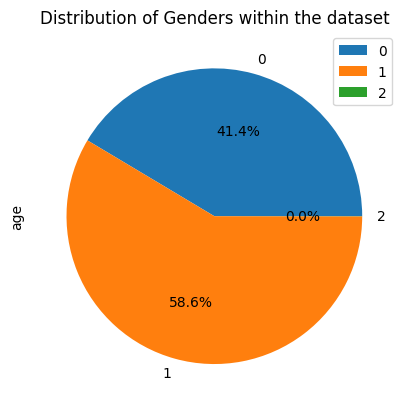

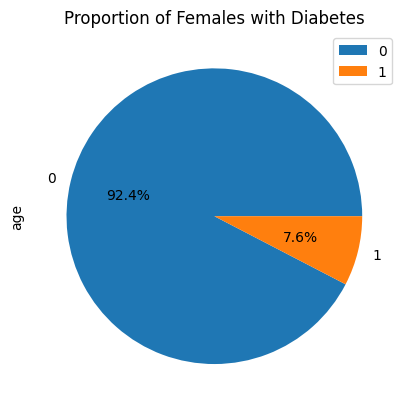

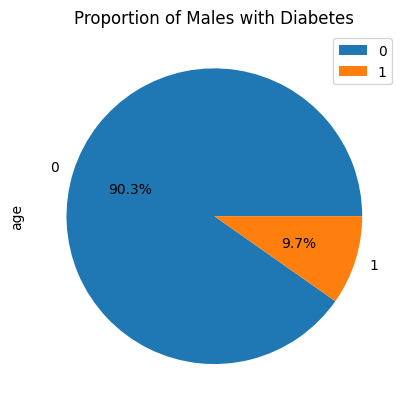

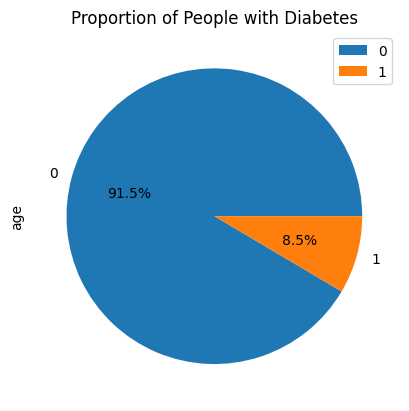

In [167]:
mf_split = raw_df[["gender", "age"]].groupby("gender").count()
mf_split.plot.pie(y="age", autopct='%1.1f%%', title="Distribution of Genders within the dataset")

f_split = raw_df[raw_df["gender"] == 1]
f_diabetes_split = f_split[["age", "diabetes"]].groupby("diabetes").count()
f_diabetes_split.plot.pie(y="age", autopct='%1.1f%%', title="Proportion of Females with Diabetes")

m_split = raw_df[raw_df["gender"] == 0]
m_diabetes_split = m_split[["age", "diabetes"]].groupby("diabetes").count()
m_diabetes_split.plot.pie(y="age", autopct='%1.1f%%', title="Proportion of Males with Diabetes")

diabetes_split = raw_df[["age", "diabetes"]].groupby("diabetes").count()
diabetes_split.plot.pie(y="age", autopct='%1.1f%%', title="Proportion of People with Diabetes")

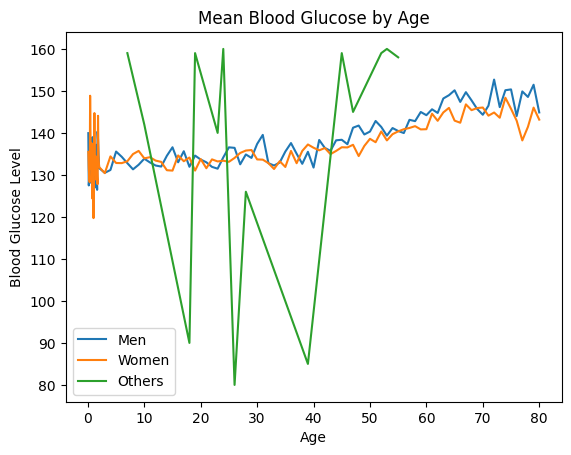

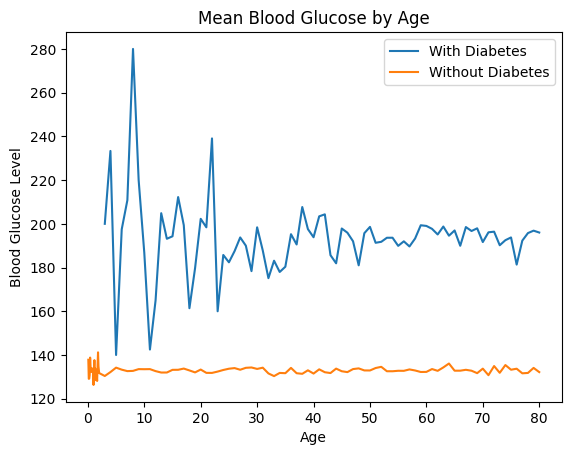

In [168]:
# Line chart of Age against blood Glucose
#Men/Women
o_split = raw_df[raw_df["gender"] == 2]

m_glucose_split = m_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()
f_glucose_split = f_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()
o_glucose_split = o_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()

plt.plot(m_glucose_split["age"], m_glucose_split["blood_glucose_level"], label="Men")
plt.plot(f_glucose_split["age"], f_glucose_split["blood_glucose_level"], label="Women")
plt.plot(o_glucose_split["age"], o_glucose_split["blood_glucose_level"], label="Others")
plt.title("Mean Blood Glucose by Age")
plt.xlabel("Age")
plt.ylabel("Blood Glucose Level")
plt.legend()
plt.show()
#Diabetes or no

diabetes_split = raw_df[raw_df["diabetes"] == 1]
no_diabetes_split = raw_df[raw_df["diabetes"] == 0]

diabetes_glucose_grouped = diabetes_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()
no_diabetes_glucose_grouped = no_diabetes_split[["age", "blood_glucose_level"]].groupby("age").mean().reset_index()

plt.plot(diabetes_glucose_grouped["age"], diabetes_glucose_grouped["blood_glucose_level"], label="With Diabetes")
plt.plot(no_diabetes_glucose_grouped["age"], no_diabetes_glucose_grouped["blood_glucose_level"], label="Without Diabetes")
plt.title("Mean Blood Glucose by Age")
plt.xlabel("Age")
plt.ylabel("Blood Glucose Level")
plt.legend()
plt.show()

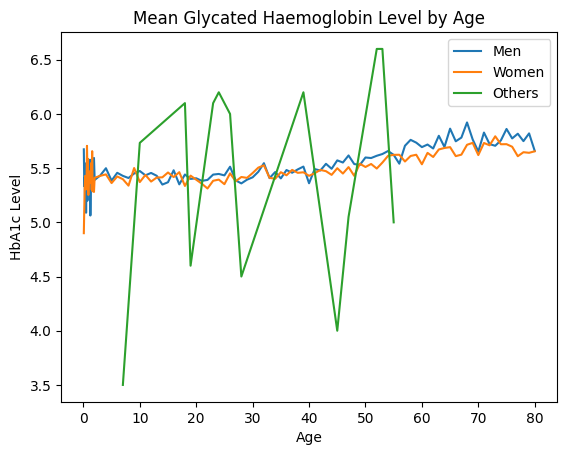

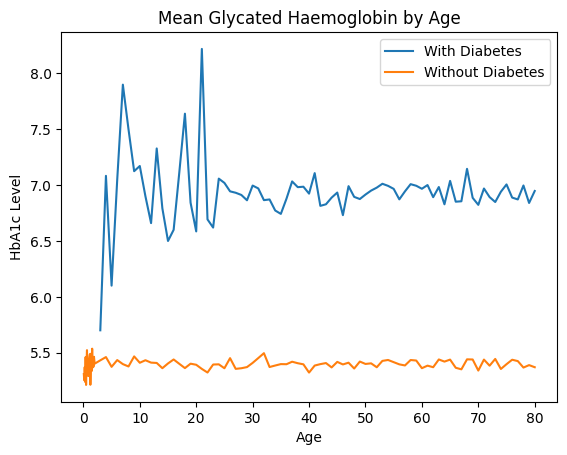

In [169]:
# Line chart of Age against blood Glucose
#Men/Women
m_HbA1c_split = m_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()
f_HbA1c_split = f_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()
o_HbA1c_split = o_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()

plt.plot(m_HbA1c_split["age"], m_HbA1c_split["HbA1c_level"], label="Men")
plt.plot(f_HbA1c_split["age"], f_HbA1c_split["HbA1c_level"], label="Women")
plt.plot(o_HbA1c_split["age"], o_HbA1c_split["HbA1c_level"], label="Others")
plt.title("Mean Glycated Haemoglobin Level by Age")
plt.xlabel("Age")
plt.ylabel("HbA1c Level")
plt.legend()
plt.show()
# Diabetes or no

diabetes_HbA1c_grouped = diabetes_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()
no_diabetes_HbA1c_grouped = no_diabetes_split[["age", "HbA1c_level"]].groupby("age").mean().reset_index()

plt.plot(diabetes_HbA1c_grouped["age"], diabetes_HbA1c_grouped["HbA1c_level"], label="With Diabetes")
plt.plot(no_diabetes_HbA1c_grouped["age"], no_diabetes_HbA1c_grouped["HbA1c_level"], label="Without Diabetes")
plt.title("Mean Glycated Haemoglobin by Age")
plt.xlabel("Age")
plt.ylabel("HbA1c Level")
plt.legend()
plt.show()

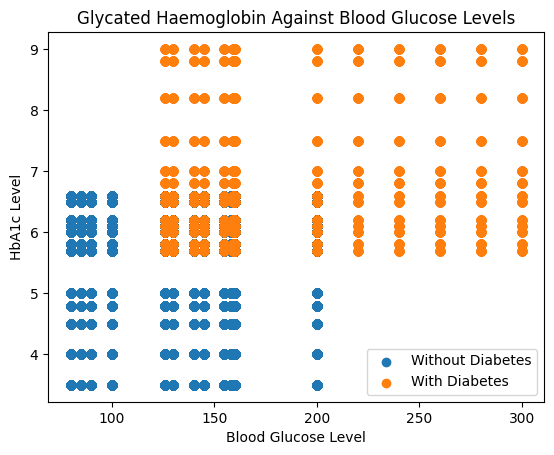

In [170]:
plt.scatter(no_diabetes_split["blood_glucose_level"], no_diabetes_split["HbA1c_level"], label="Without Diabetes")
plt.scatter(diabetes_split["blood_glucose_level"], diabetes_split["HbA1c_level"], label="With Diabetes")
plt.title("Glycated Haemoglobin Against Blood Glucose Levels")
plt.xlabel("Blood Glucose Level")
plt.ylabel("HbA1c Level")
plt.legend()
plt.show()

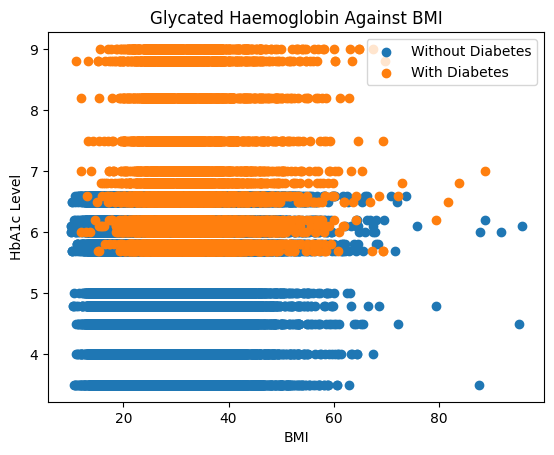

In [171]:
plt.scatter(no_diabetes_split["bmi"], no_diabetes_split["HbA1c_level"], label="Without Diabetes")
plt.scatter(diabetes_split["bmi"], diabetes_split["HbA1c_level"], label="With Diabetes")
plt.title("Glycated Haemoglobin Against BMI")
plt.xlabel("BMI")
plt.ylabel("HbA1c Level")
plt.legend()
plt.show()

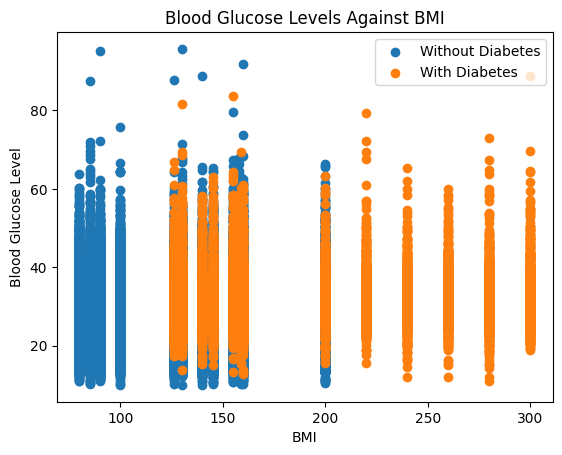

In [172]:
plt.scatter(no_diabetes_split["blood_glucose_level"], no_diabetes_split["bmi"], label="Without Diabetes")
plt.scatter(diabetes_split["blood_glucose_level"], diabetes_split["bmi"], label="With Diabetes")
plt.title("Blood Glucose Levels Against BMI")
plt.xlabel("BMI")
plt.ylabel("Blood Glucose Level")
plt.legend()
plt.show()

<Axes: title={'center': 'Smoking History of Diabetics within the dataset'}, ylabel='age'>

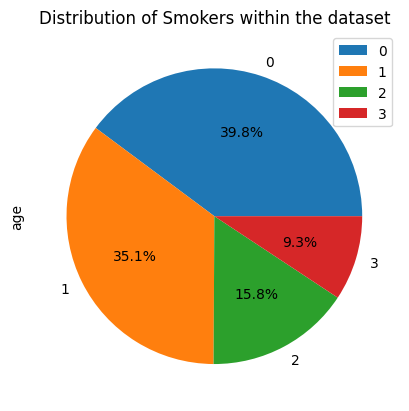

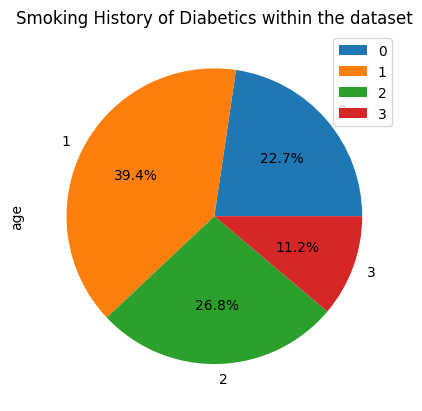

In [173]:
mf_split = raw_df[["smoking_history", "age"]].groupby("smoking_history").count()
mf_split.plot.pie(y="age", autopct='%1.1f%%', title="Distribution of Smokers within the dataset")

diabetic_smoker_split = diabetes_split[["smoking_history", "age"]].groupby("smoking_history").count()
diabetic_smoker_split.plot.pie(y="age", autopct='%1.1f%%', title="Smoking History of Diabetics within the dataset")

<Axes: title={'center': 'Hypertensive Diabetics within the dataset'}, ylabel='age'>

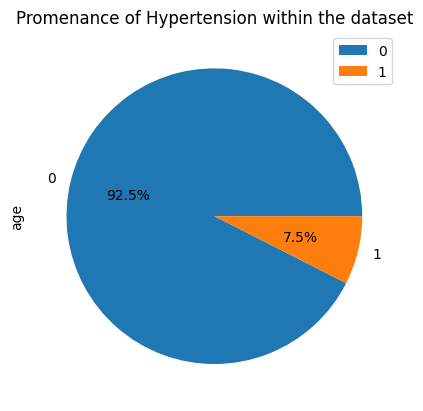

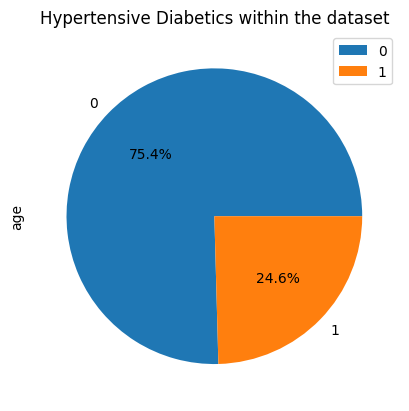

In [174]:
mf_split = raw_df[["hypertension", "age"]].groupby("hypertension").count()
mf_split.plot.pie(y="age", autopct='%1.1f%%', title="Promenance of Hypertension within the dataset")

diabetic_smoker_split = diabetes_split[["hypertension", "age"]].groupby("hypertension").count()
diabetic_smoker_split.plot.pie(y="age", autopct='%1.1f%%', title="Hypertensive Diabetics within the dataset")

<Axes: title={'center': 'Diabetics with Heart Disease within the dataset'}, ylabel='age'>

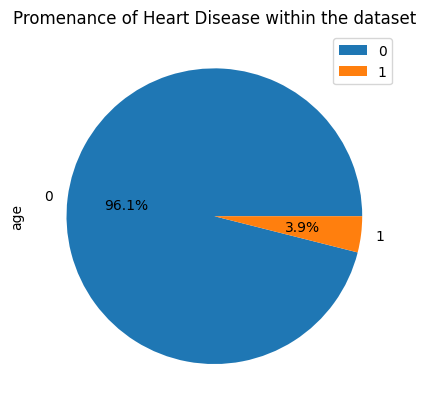

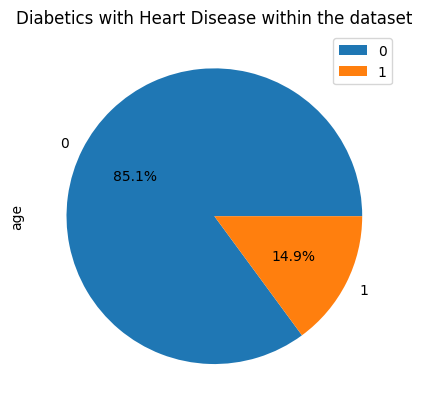

In [175]:
mf_split = raw_df[["heart_disease", "age"]].groupby("heart_disease").count()
mf_split.plot.pie(y="age", autopct='%1.1f%%', title="Promenance of Heart Disease within the dataset")

diabetic_smoker_split = diabetes_split[["heart_disease", "age"]].groupby("heart_disease").count()
diabetic_smoker_split.plot.pie(y="age", autopct='%1.1f%%', title="Diabetics with Heart Disease within the dataset")

#### Step 3: Selection of Machine Learning Models to use
- Use Random Forest Classifier to determine Feature Importance

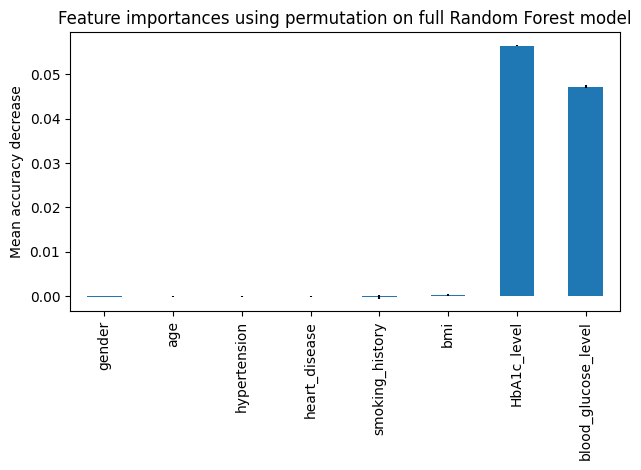

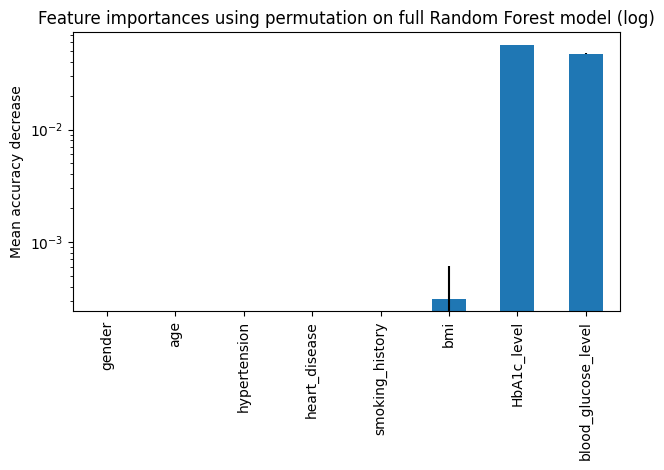

HbA1c_level            0.056448
blood_glucose_level    0.047232
bmi                    0.000312
hypertension          -0.000028
age                   -0.000028
heart_disease         -0.000052
gender                -0.000184
smoking_history       -0.000184
dtype: float64


In [176]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

forest = RandomForestClassifier(n_estimators=750)
forest.fit(train_features, train_labels)

rf_perm_importance = permutation_importance(forest, test_features, test_labels, n_repeats=5, n_jobs=-1)

rf_importances = pd.Series(rf_perm_importance.importances_mean, index=feature_names)

rf_importances.plot.bar(yerr=rf_perm_importance.importances_std)
plt.title("Feature importances using permutation on full Random Forest model")
plt.ylabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

rf_importances.plot.bar(yerr=rf_perm_importance.importances_std, logy=True)
plt.title("Feature importances using permutation on full Random Forest model (log)")
plt.ylabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

print(rf_importances.sort_values(ascending=False))

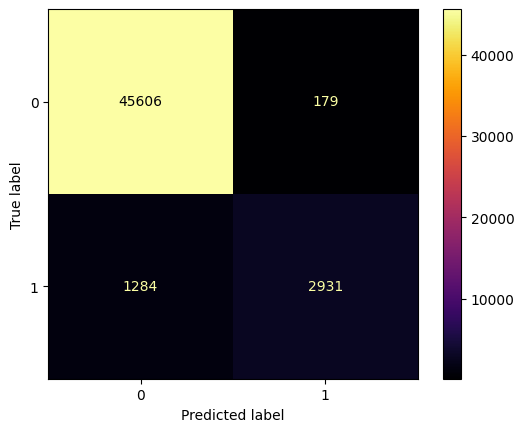

In [177]:
from sklearn.metrics import ConfusionMatrixDisplay

rf_cm = ConfusionMatrixDisplay.from_estimator(forest, test_features, test_labels, cmap="inferno")

In [178]:
rf_accuracy = forest.score(test_features, test_labels)
rf_accuracy

0.97074

#### SVM Implementation

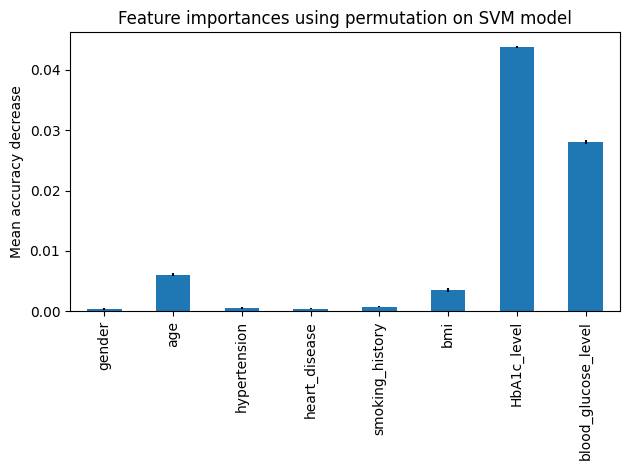

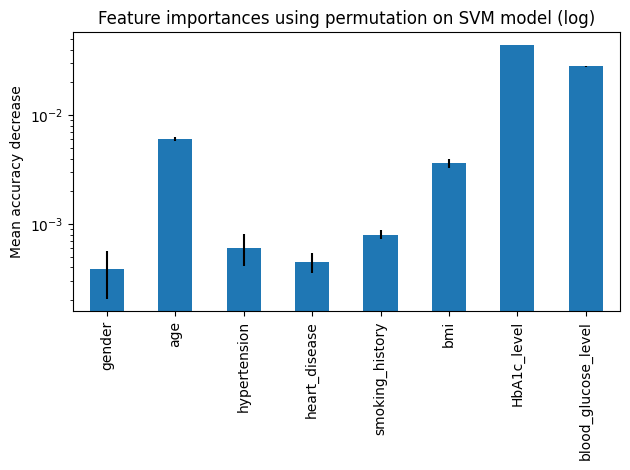

HbA1c_level            0.043807
blood_glucose_level    0.028013
age                    0.006080
bmi                    0.003600
smoking_history        0.000800
hypertension           0.000607
heart_disease          0.000453
gender                 0.000387
dtype: float64


In [179]:
from sklearn.svm import SVC

svm = SVC(kernel="linear")
svm.fit(train_features, train_labels)

svm_perm_importance = permutation_importance(svm, test_features, test_labels, n_repeats=3, n_jobs=-1)

svm_importances = pd.Series(svm_perm_importance.importances_mean, index=feature_names)

svm_importances.plot.bar(yerr=svm_perm_importance.importances_std)
plt.title("Feature importances using permutation on SVM model")
plt.ylabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

svm_importances.plot.bar(yerr=svm_perm_importance.importances_std, logy=True)
plt.title("Feature importances using permutation on SVM model (log)")
plt.ylabel("Mean accuracy decrease")
plt.tight_layout()
plt.show()

print(svm_importances.sort_values(ascending=False))

0.97074

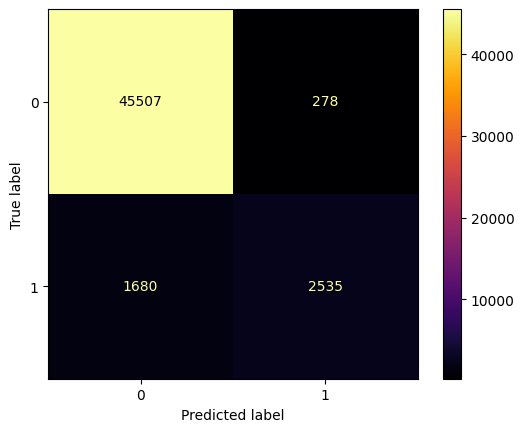

In [180]:
svm_cm = ConfusionMatrixDisplay.from_estimator(svm, test_features, test_labels, cmap="inferno")
svm_accuracy = forest.score(test_features, test_labels)
svm_accuracy